In [2]:
from github import Github
from dotenv import load_dotenv
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import pandas as pd
import seaborn as sns


/home/logan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [20]:
!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

Defaulting to user installation because normal site-packages is not writeable
Obtaining bq_helper from git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
  Updating ./src/bq-helper clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f
  Preparing metadata (setup.py) ... done
  Running setup.py develop for bq_helper


In [18]:
import bq_helper

load_dotenv()

True

In [24]:
github_token = os.environ.get('GITHUB_ACCESS_TOKEN')
g = Github(github_token)
username = "loganoneal"

# Questions: How has the most used language on Github changed over time for a single user and overall? What does the distrubiution of languages I ahve worked on looklike? What does the overall distrubution look lie? 

### Visualize the distrobution of repos I ahve worked on

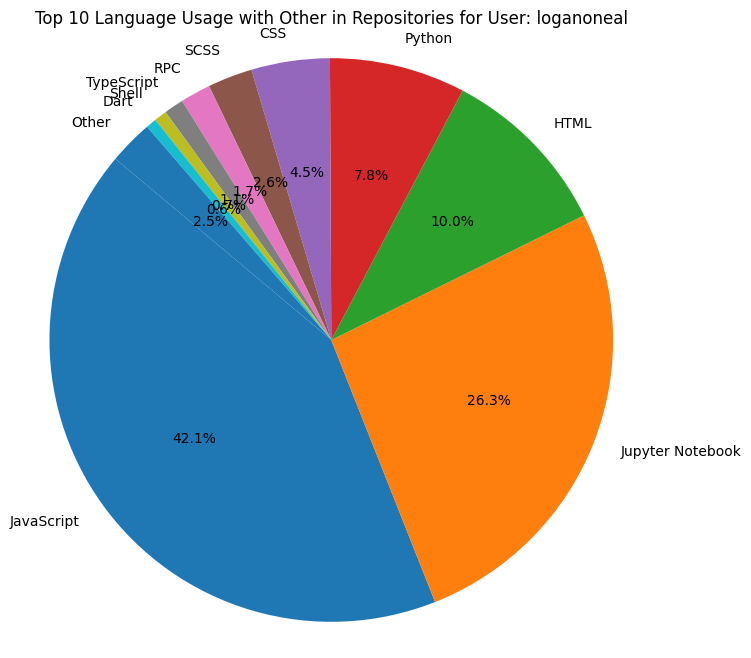

In [27]:
user = g.get_user(username)

language_usage = defaultdict(int)

for repo in user.get_repos():
    creation_year = repo.created_at.year
    
    languages = repo.get_languages()
    
    for lang, bytes_used in languages.items():
        language_usage[lang] += bytes_used

# Sort the language usage and get the top 10 languages
sorted_languages = sorted(language_usage.items(), key=lambda item: item[1], reverse=True)
top_languages = dict(sorted_languages[:10])

# Calculate the total usage of languages outside the top 10
other_languages_total = sum(val for _, val in sorted_languages[10:])

# Create a new dictionary with top 10 languages and an "other" category
top_languages_with_other = {lang: val for lang, val in top_languages.items()}
top_languages_with_other['Other'] = other_languages_total

# Visualize top 10 languages and "other" in a pie plot
labels = list(top_languages_with_other.keys())
sizes = list(top_languages_with_other.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Top 10 Language Usage with Other in Repositories for User: {}'.format(username)) 
plt.show()

### How has the most used language changed for a user? 


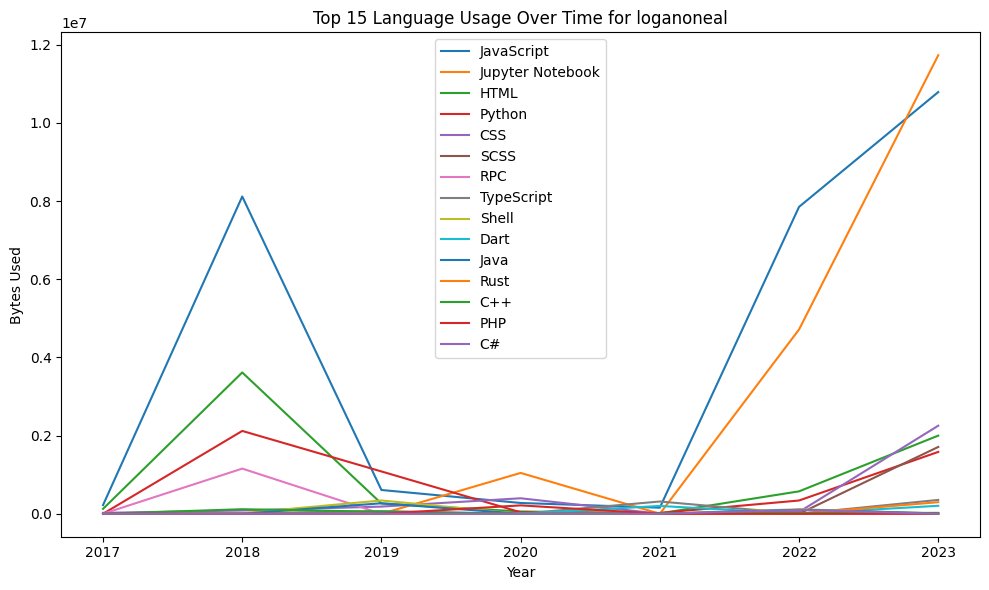

In [28]:
user = g.get_user(username)

# Dictionary to store language usage over time
language_usage_by_year = defaultdict(lambda: defaultdict(int))

# Iterate through each repository of the user
for repo in user.get_repos():
    # Get repository creation year
    creation_year = repo.created_at.year
    
    # Get languages used in the repository
    languages = repo.get_languages()
    
    # Update language usage count for the specific year
    for lang, bytes_used in languages.items():
        language_usage_by_year[creation_year][lang] += bytes_used

# Prepare data for plotting
languages_data = {lang: [] for lang in set(lang for year_data in language_usage_by_year.values() for lang in year_data)}
years = sorted(language_usage_by_year.keys())

for lang in languages_data:
    for year in years:
        languages_data[lang].append(language_usage_by_year[year][lang])

# Sort the languages based on their total usage
top_languages = sorted(languages_data.keys(), key=lambda lang: sum(languages_data[lang]), reverse=True)[:15]

# Create a stacked area plot for the top 10 languages
plt.figure(figsize=(10, 6))

for lang in top_languages:
    plt.plot(years, languages_data[lang], label=lang)

plt.xlabel('Year')
plt.ylabel('Bytes Used')
plt.title(f'Top 15 Language Usage Over Time for {username}')
plt.legend()
plt.tight_layout()
plt.show()

### How has the most used language changed for all Github Users?

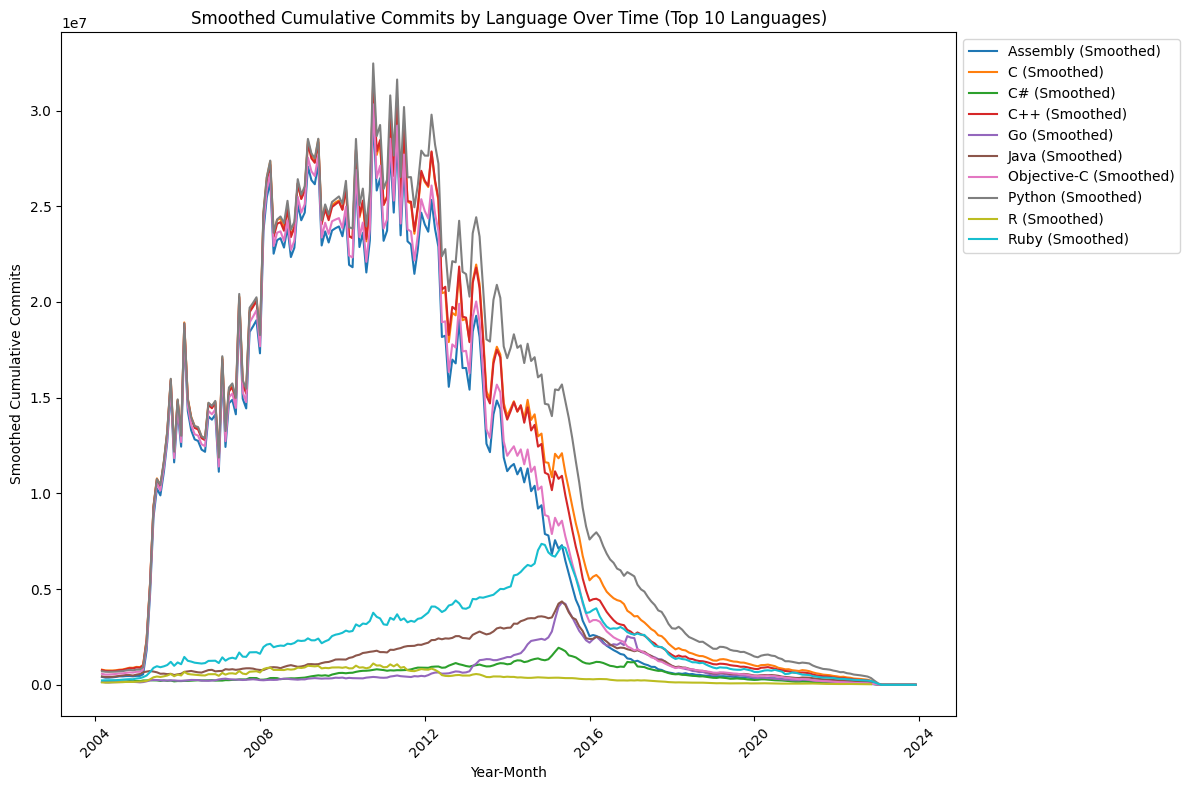

In [34]:
df = pd.read_csv("data/languages_by_commits.csv")  # data from biquery api run in colab (cant run in jupyter, original file too large)
df.sort_values( by=["YearMonth", "CommitCnts"], ascending=False ).head(10)
mask = df['LangName'].isin(['Python', 'C', 'C++', 'Java', 'Go', 'Ruby', 'Objective-C', 'Assembly', 'Swift', 'Kotlin', 'R', 'C#']) 
df = df[mask]
df.rename(columns={ "CommitCnts" : "value"}, inplace=True)
df.rename(columns={ "LangName" : "name"}, inplace=True)
df.rename(columns={ "YearMonth" : "YEAR_MONTH"}, inplace=True)
df['YEAR_MONTH'] = pd.to_datetime(df['YEAR_MONTH'])
df = df[df['YEAR_MONTH'].dt.year.between(2004, 2023)]

mask = df['name'].isin(['Python', 'C', 'C++', 'Java', 'Go', 'Ruby', 'Objective-C', 'Assembly', 'Swift', 'Kotlin', 'R', 'C#']) 
df = df[mask]
# Assuming your DataFrame is named df
# Convert the 'YearMonth' column to datetime type
df['YEAR_MONTH'] = pd.to_datetime(df['YEAR_MONTH'], format='%Y-%m')

# Sort the DataFrame by 'YearMonth' for cumulative sum to work correctly
df = df.sort_values(by='YEAR_MONTH')

# Determine the top 10 languages based on total commits
top_languages = df.groupby('name')['value'].sum().nlargest(10).index

# Filter the DataFrame to include only the top 10 languages
df_top10 = df[df['name'].isin(top_languages)]

# Smooth the line plots for each language
plt.figure(figsize=(12, 8))
for lang, data in df_top10.groupby('name'):
    # Calculate the rolling average with a window size of 3 (you can adjust this)
    data['smoothed_value'] = data['value'].rolling(window=3).mean()
    
    # Plot the smoothed line
    plt.plot(data['YEAR_MONTH'], data['smoothed_value'], label=f'{lang} (Smoothed)')

plt.title('Smoothed Cumulative Commits by Language Over Time (Top 10 Languages)')
plt.xlabel('Year-Month')
plt.ylabel('Smoothed Cumulative Commits')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
df = pd.read_csv("data/languages_by_commits.csv") 
df.sort_values( by=["YearMonth", "CommitCnts"], ascending=False ).head(10)
mask = df['LangName'].isin(['Python', 'C', 'C++', 'Java', 'Go', 'Ruby', 'Objective-C', 'Assembly', 'Swift', 'Kotlin', 'R', 'C#']) 
df = df[mask]
df.rename(columns={ "CommitCnts" : "value"}, inplace=True)
df.rename(columns={ "LangName" : "name"}, inplace=True)
df.rename(columns={ "YearMonth" : "YEAR_MONTH"}, inplace=True)

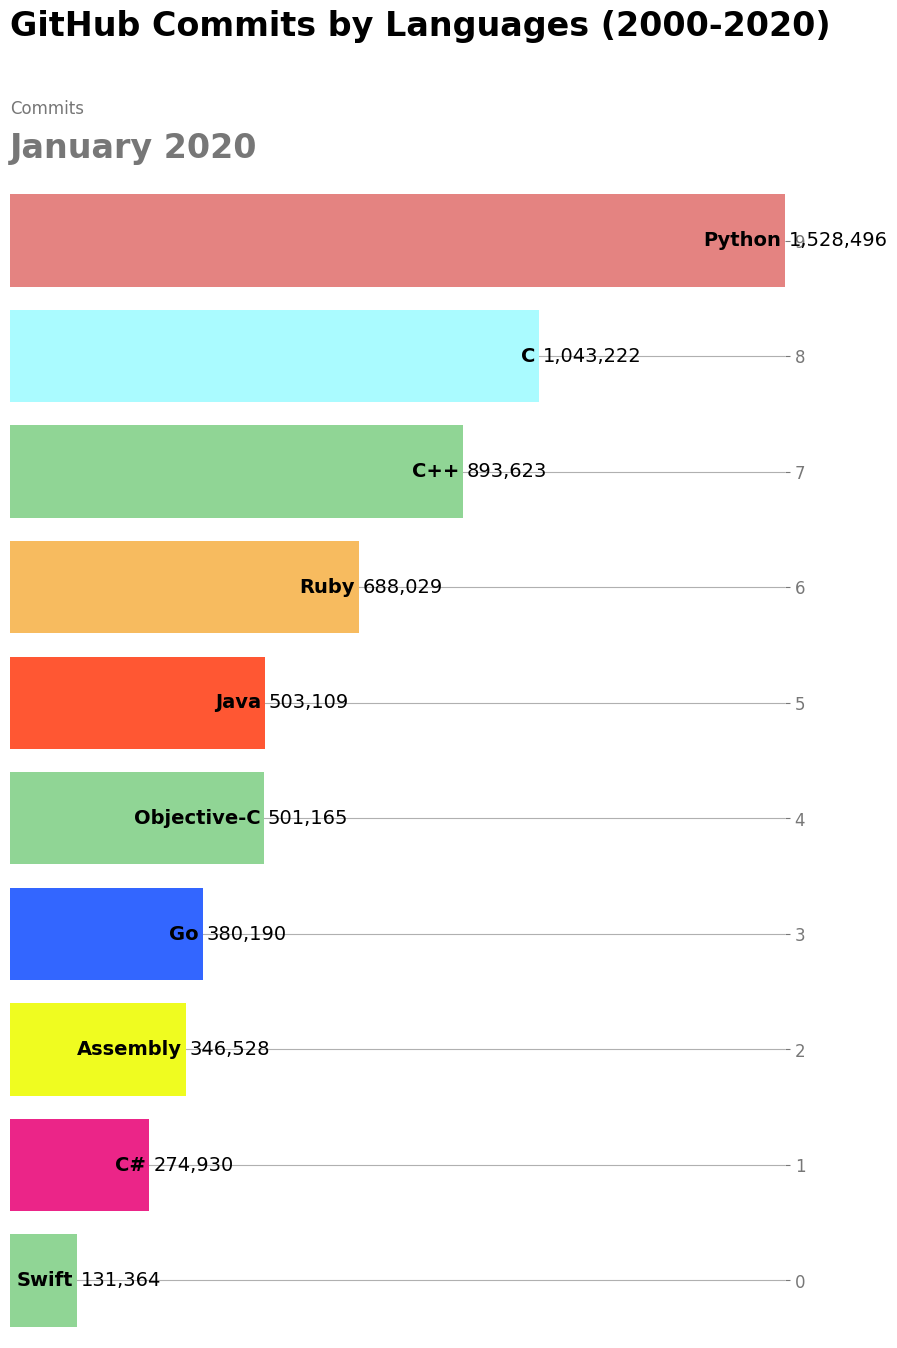

In [6]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dateutil import parser

colors = {
    "Java": "#FF5733",
    "Go": "#3366FF",
    "C++": "#90d595",
    "Python": "#e48381",
    "C": "#aafbff",
    "Ruby": "#f7bb5f",
    "Assembly": "#effc20",
    "Objective-C": "#90d595",
    "Kotlin": "#f7bb5f",
    "Swift": "#90d595",
    "C#": "#eb2588"
}
default_color = "#FFA500"  # Changing default color

# Assuming you have a list of unique year-month combinations in 'year_month_list'
year_month_list = ['2000-1', '2000-2', ...]  # Your list of year-month combinations

fig, ax = plt.subplots(figsize=(10, 15))  # Adjusting figure size for vertical display

def draw_barchart(current_year_month):
    dff = df[df['YEAR_MONTH'].eq(current_year_month)].sort_values(by='value', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['name'], dff['value'], color=[colors.get(x, default_color) for x in dff['name']])
    dx = dff['value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
        ax.text(value - dx, i, name, size=14, weight=600, ha='right', va='center')
        ax.text(value + dx, i, f'{value:,.0f}', size=14, ha='left', va='center')
    dt = parser.parse(current_year_month)
    ax.text(0, 1.03, dt.strftime("%B %Y"), transform=ax.transAxes, color='#777777', size=24, ha='left', va='center', weight=800)
    ax.text(0, 1.06, 'Commits', transform=ax.transAxes, size=12, color='#777777')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_ticks_position('right')
    ax.tick_params(axis='y', colors='#777777', labelsize=12)
    ax.set_xticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='y', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'GitHub Commits by Languages (2000-2020)',  # Changing title
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)

draw_barchart('2020-1')
plt.show()